In [167]:
pwd

'/local/Dropbox/dev/geocomputing/dev'

# Linear regression

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/RPC_4_lithologies.csv')

df

,RPC,Description,Lithology,Vp,Vs,Rho,Rho_n
0,104818,KIAMICHI FORMA. 4,sandstone,3045.60,1595.70,2108.0,2109.120585
1,104893,KIAMICHI REMOLD 3,sandstone,3000.60,1517.10,2126.0,2090.342013
2,104652,NAVAJO ARCO 2,sandstone,3363.60,2041.50,2162.0,2131.989982
3,104752,NAVAJO ARCO REMOL 1,sandstone,3195.30,1606.20,2160.0,2184.939233
4,104598,FERRON 82-3 1677.5,sandstone,4237.50,2448.60,2428.0,2472.230768
...,...,...,...,...,...,...,...
795,102178,R.PRICE 10909.5 #31,dolomite,4625.98,2759.19,2370.0,2414.016690
796,102225,R.PRICE 10916.5 #38,dolomite,5446.19,3116.80,2440.0,2475.729186
797,102088,R.PRICE 10883.5 #7,dolomite,5446.19,2998.69,2570.0,2521.125328
798,102213,R.PRICE 10913.5 #35,dolomite,5347.77,2933.07,2440.0,2470.806475


In [50]:
df['Rho'] = df['Rho'] / 1000

### EXERCISE

- Drop the `RPC` and `Rho_n` columns.
- Answer these questions:
  - How many records are there?
  - How many incomplete records are there? (Records with missing values.)
  - How many instances of each lithology are there?
  - Two of the properties are strongly correlated; which two?
  - What do you notice about the Rho data?
  - What do you notice about the sandstone data?

In [2]:
df = df.drop(columns=['RPC', 'Rho_n'])

In [3]:
df.describe()

,Vp,Vs,Rho
count,800.000000,800.000000,752.000000
mean,3798.453532,2113.480238,2316.454788
std,1114.387572,750.387638,255.652892
min,1490.711927,441.270000,1750.000000
25%,3010.248889,1520.975000,2117.000000
50%,3675.150000,2198.100000,2390.000000
75%,4664.592178,2733.805000,2530.000000
max,5993.000000,3665.000000,2780.000000


In [4]:
df.Lithology.value_counts()

sandstone    200
shale        200
limestone    200
dolomite     200
Name: Lithology, dtype: int64

In [5]:
from collections import Counter

Counter([s[0] for s in df.loc[df.Lithology=='sandstone'].Description.str.split()])

Counter({'KIAMICHI': 42, 'NAVAJO': 90, 'FERRON': 67, 'Gas': 1})

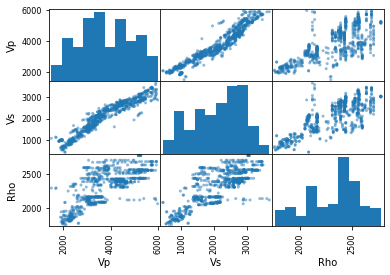

In [6]:
_ = pd.plotting.scatter_matrix(df)

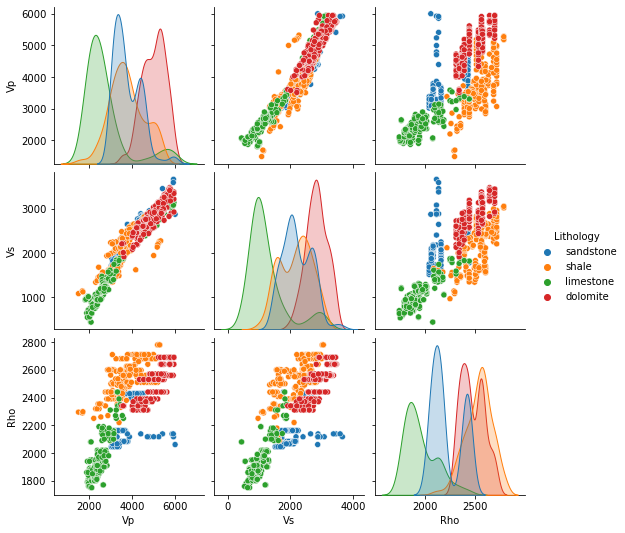

In [7]:
import seaborn as sns

sns.pairplot(df, hue='Lithology')

---

## Predict `Vs` from Vp

While we get used to the idea of regression, let's start with something fairly striaghtforward: predicting one thing from one other thing. In ML-speak, this is a 'one-dimensional' problem, because an input to the model will have only 1 feature or 'dimension'.

We'll predict Vs from Vp, because that's a really common thing to want to do.


### Make `X` and `y`

We call the inputs `X` (usually this is a matrix, i.e. a 2D array), and the output `y` (usually a vector, i.e. a 1D array).

In [8]:
X = df['Vp'].values
y = df['Vs'].values

X.shape

(800,)

In [9]:
X = X.reshape(-1, 1)

X.shape

(800, 1)

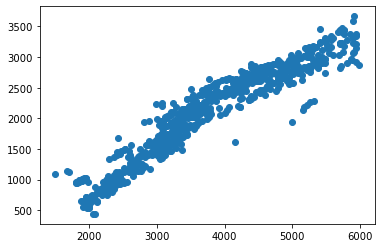

In [10]:
import matplotlib.pyplot as plt

plt.scatter(X, y)

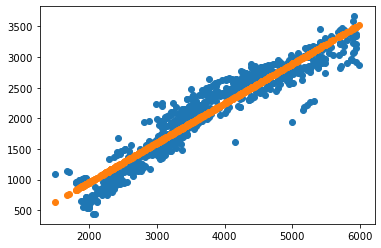

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X, y)

y_pred = model.predict(X)

plt.scatter(X, y)
plt.scatter(X, y_pred)

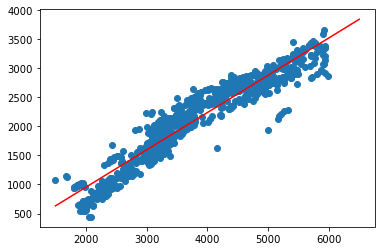

In [34]:
# Draw an arbitrary line for the best fit:
X_syn = np.linspace(1500, 6500).reshape(-1, 1)
y_syn = model.predict(X_syn)

plt.scatter(X, y)
plt.plot(X_syn, y_syn, c='red')

In [35]:
model.coef_

array([0.64325434])

In [36]:
model.intercept_

-333.2331692807411

### `X` as an augmented matrix

Let's imagine we have an expression like:

$$ \hat{y} = w_1 x^1 + w_0 x^0 $$

In [45]:
X_ = np.vstack([X.flat, np.ones(X.size)]).T
X_[:5]

array([[3.0456e+03, 1.0000e+00],
       [3.0006e+03, 1.0000e+00],
       [3.3636e+03, 1.0000e+00],
       [3.1953e+03, 1.0000e+00],
       [4.2375e+03, 1.0000e+00]])

In [49]:
model = LinearRegression(fit_intercept=False)  # <-- important.

model.fit(X_, y, )

model.coef_, model.intercept_

(array([   0.64261339, -327.45685506]), 0.0)

## Validation

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_val.shape

((640, 1), (160, 1))

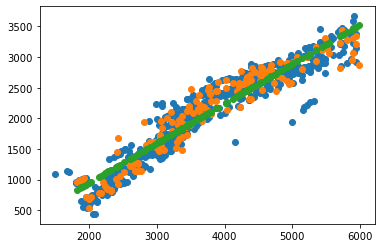

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

plt.scatter(X_train, y_train)
plt.scatter(X_val, y_val)
plt.scatter(X_val, y_pred)

In [28]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def score(y_true, y_predicted):
    """
    Return the R2 and RMSE scores for a regression.
    
    Args:
        y_true (array): The true values, e.g. y_val or y_test.
        y_predicted (array): The predicted values.
        
    Returns:
        tuple: The R2 score and the RMSE.
        
    Example:
        >>> score([0.5, 1.5, 2.5], [0.5, 1.5, 2.5])
        (1.0, 0.0)
        >>> score([0.5, 1.5, 2.5], [0.4, 1.5, 2.6])
        (0.99, 0.08164965809277262)
    """
    return r2_score(y_true, y_predicted), np.sqrt(mean_squared_error(y_true, y_predicted))

score(y_val, y_pred)

(0.9128160415665872, 219.59798073828102)

In [30]:
import doctest

doctest.testmod(verbose=True)

Trying:
    score([0.5, 1.5, 2.5], [0.5, 1.5, 2.5])
Expecting:
    (1.0, 0.0)
ok
Trying:
    score([0.5, 1.5, 2.5], [0.4, 1.5, 2.6])
Expecting:
    (0.99, 0.08164965809277262)
ok
1 items had no tests:
    __main__
1 items passed all tests:
   2 tests in __main__.score
2 tests in 2 items.
2 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=2)

## Add another feature

We know that `Vs` is related to `Vp`, but know it is also related to density, `rho`. So we should be able to get a better fit by adding that feature:

In [64]:
features = ['Vp', 'Rho']

df_ = df.dropna()  # <-- Important.

X = df_[features].values
y = df_['Vs'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

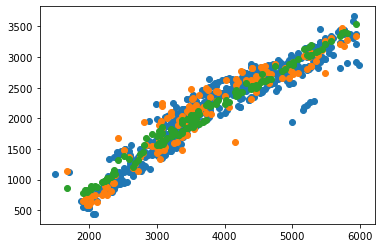

In [67]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_val[:, 0], y_val)
plt.scatter(X_val[:, 0], y_pred)

In [68]:
score(y_val, y_pred)

(0.9194567121320073, 211.38122066457288)

## Add interactions and/or polynomial features

Linear algorithms can actually model nonlinear relationships! For example, although this relationship is not linear with respect to x, this model is linear respect to the parameters:

$$ \hat{y} = w_2 x^2 + w_1 x + w_0 $$

Note that this is not called "nonlinear regression", which involves optimizing parameters in expressions like $\hat{y} = a \mathrm{r}^{bx}$, but is sometimes called **polynomial regression**. Transforming `X` in this way is sometimes called **basis expansion** ([read more](http://madrury.github.io/jekyll/update/statistics/2017/08/04/basis-expansions.html)).

Adding polynomial relationships is really a generalization of adding **feature interactions**. For example, if I have features $x_1$ and $x_2$, I can add $x_1 x_2$. The full 2nd degree polynomial expansion then looks like this:

$$ \hat{y} = w_5 x_1^2 + w_4 x_2^2 + w_3 x_1 x_2 + w_2 x_1 + w_1 x_2 + w_0 $$

So instead of having just two features and fitting three parameters, I have five features and six parameters. This allows me to make a more complex model that can capture more variance in the data. But complexity always comes with the risk of overfitting!

The way to add these new features is with `sklearn.preprocessing.PolynomialFeatures()` (specifying the degree and whether you only want interactions, or polynomial features as well). And the easiest way to include this step is in an `sklearn.pipline.Pipeline`:

In [159]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=6), LinearRegression())

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

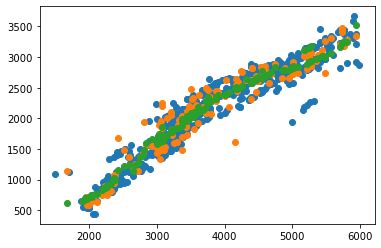

In [160]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_val[:, 0], y_val)
plt.scatter(X_val[:, 0], y_pred)

In [161]:
score(y_val, y_pred)

(0.9346802440899631, 190.35925702439204)

## Add regularization

If overfitting becomes an issue, we can add **regularization**. Applying L2 regularization requires the `Ridge` algorithm; applying L1 regularization requires the `Lasso` algorithm (or you can combine them with `ElasticNet`).

Regularization adds a constraint to the model parameters, preventing them from getting too large. This has the effect of 'smoothing' the model, making it less complex and therefore less able to overfit to the training data.

Many algorithms in machine learning use regularization of one kind or another, or have other hyperparameters that have essentially the same effect. The idea is always to somehow prevent the model from becoming too complex.

In [165]:
from sklearn.linear_model import Ridge

model = make_pipeline(PolynomialFeatures(degree=6), Ridge())

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

score(y_val, y_pred)

/home/matt/miniconda3/envs/geoml/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79824e-47): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


(0.9427868505919599, 178.15567130327747)

In [166]:
model.named_steps['ridge'].coef_

array([ 0.00000000e+00,  1.52187412e+02, -1.41910527e+00, -1.35586776e-01,
       -9.28524522e+00, -3.28071260e+00,  2.00270142e-05,  1.35949931e-01,
       -1.06109499e+02, -3.75322060e+00, -6.04259851e-09,  1.20930823e-05,
       -1.10519931e-01,  1.09303405e+02,  2.44565098e+00,  5.28329598e-13,
        8.39866922e-10, -7.51398261e-06,  4.08813953e-02, -4.14217201e+01,
        2.80339286e+01, -2.64926670e-17,  3.36517766e-14, -2.71421762e-10,
        1.46217398e-06, -5.51409858e-03,  5.29679829e+00,  1.07981984e+02])